<a href="https://colab.research.google.com/github/rjavadi/deeplearning-notebooks/blob/master/UNet_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets
from torchvision import transforms
from torchvision.datasets import VisionDataset
import torchvision.transforms.functional as TF
from torchsummary import summary
import math

import numpy as np

from tqdm.notebook import tqdm

%load_ext autoreload

%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)


In [ ]:
assert torch.cuda.is_available(), "Make sure you are on a GPU. Please select \"runtime\" and then \"change runtime type\""

device = torch.device("cuda")
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [1]:
! git remote


fatal: not a git repository (or any of the parent directories): .git


## Timestamp Encoding
This piece of code is to embed time steps into our model, since the amount of noise added to image is proportional to the timestep, e.g. the later timestamp --> more noise.

The timestamp encoding the authors suggested is slightly different from the one in transformers.
In transformers paper we have: [sin, cos, sin, ...]
while here we have: [sin, sin, ..., cos, cos, ...]

In [ ]:
class TimestampEncoding(nn.Module):
    def __init__(self, dim, n=10000):
        super(TimestampEncoding, self).__init__()
        self.dim = dim
        self.n = n

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = torch.arange(half_dim).to(device)     # intialized to [0, 1, ...., d/2] - i in positional encoding formula
        log_factor = math.log(self.n) / (half_dim-1)        # we use ln(self.n), because later the exponentials of n may get too big?
        embeddings = torch.exp(embeddings * -log_factor) # denominator of the expression inside sin() and cos()
        # time: [B, 1] - embeddings: [B, 1, dim//2]
        embeddings = time[:, None] * embeddings[None, :]  # time is equivalent to k in formula - numerator of the expression times by denominator
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [ ]:
a = torch.randint(low=1, high=10, size=(4,))
a

In [ ]:

b = F.pad(a[:-1], (1,0), value=1.0)

In [ ]:
b

## Noise Scheduler
Here we define a simple linear noise scheduler.

In [ ]:
from torch.utils.data.distributed import Sampler
def extract(consts: torch.Tensor, t: torch.Tensor):
    t = t.to(device)
    c = torch.gather(consts, -1, t)
    return c.reshape(-1, 1, 1, 1)

def get_q_distribution(t, x_0, n_steps=200):
    beta = torch.linspace(0, 1, n_steps).to(device)
    alpha = 1. - beta
    alpha_bar = torch.cumprod(alpha, dim=0)

    sigma2 = beta
    mean = extract(alpha_bar, t) ** 0.5 * x_0
    var = 1 - extract(alpha_bar, t)

    return mean, var

def get_q_sample(t, x_0, eps=None):

    mean, var = get_q_distribution(t, x_0)
    # Create a normal distribution object
    print("********\n\n")
    print(f"{mean=}, {var=}")
    constraint = torch.distributions.constraints.greater_than(lower_bound=0.0)
    valid = constraint.check(var)
    normal_dist = torch.distributions.Normal(mean, var)

    # Sample from the normal distribution
    sample = normal_dist.sample()
    # print(sample.shape)

    # return mean + (var ** 0.5) * eps
    return sample

x0 = torch.rand(size=(2, 3, 4, 4)).to(device)
t = torch.tensor([3, 1])
xt = get_q_sample(t, x0)
print(xt)

## Dataloader

In [ ]:
import matplotlib.pyplot as plt

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():

    data_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ])

    train_data = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transform)
    test_data = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transform, split='test')

    return torch.utils.data.ConcatDataset([train_data, test_data])


def show_tensor_img(img):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
        transforms.ToPILImage()])

    # Take first image of batch
    if len(img.shape) == 4:
        img = img[0, :, :, :]
    plt.imshow(reverse_transforms(img))



### Visualize noise on a sample image


In [ ]:
data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

image = next(iter(dataloader))[0].to(device)
T = 20
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img = get_q_sample(t+1, image)
    show_tensor_img(img)

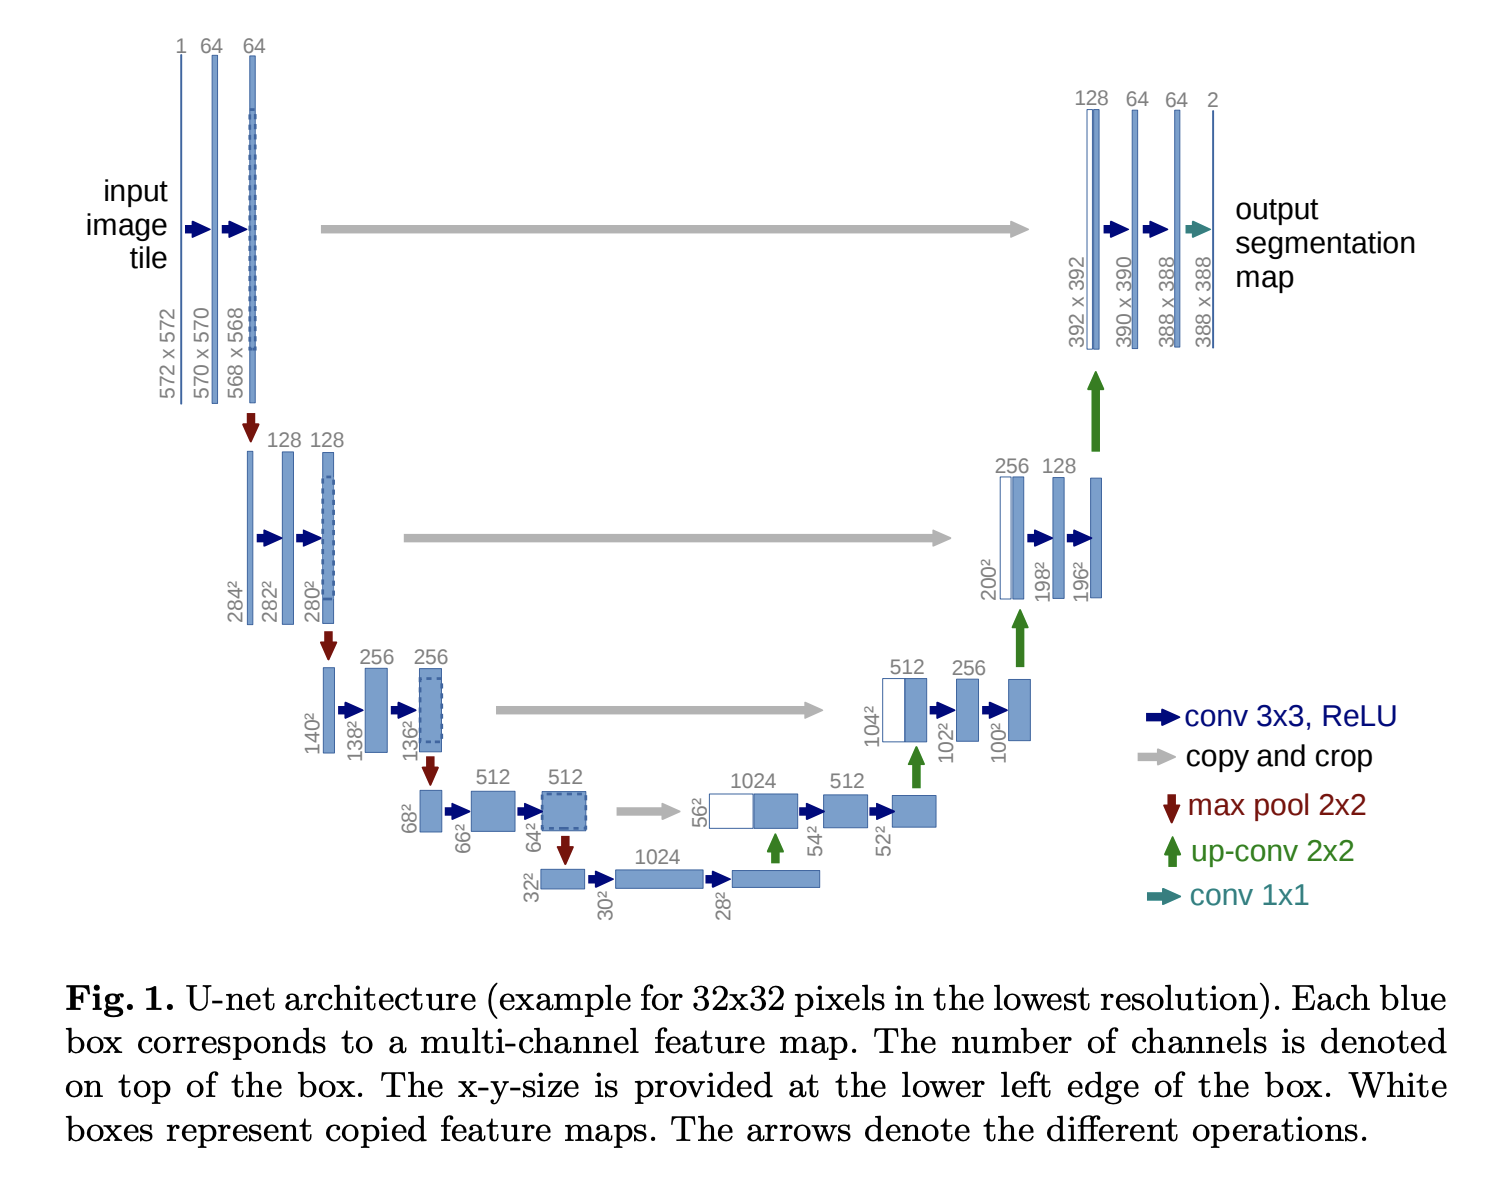

## UNet


In [ ]:
class ExpanConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super(ExpanConvBlock, self).__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1) # [B, out_ch, H, W]
        # padding='valid' is the same as no padding. padding='same' pads the input so the output has the shape as the input.
        self.conv2 = nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        # TODO: add batch norm
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)

    def forward(self, x, t):
        x = self.bnorm1(F.relu(self.conv1(x)))   # [B, out_ch, H, W]
        time_emb = F.relu(self.time_mlp(t))      # [B, out_ch]
        # Extend last 2 dimensions
        time_emb = time_emb[..., None, None]        # [B, out_ch, 1, 1]
        print(time_emb.shape)
        # time_emb = time_emb[(..., ) + (None, ) * 2]
        x = x + time_emb    # x: [B, out_ch, H, W] - each of the embedding values are added to a corresponding channel
        print(x.shape)
        x = self.bnorm2(F.relu(self.conv2(x)))   # [B, out_ch, H, W]

        return x


class ContConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super(ContConvBlock, self).__init__()
        # TODO: add time embedding mlp
        # self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=out_ch*2, out_channels=out_ch, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.bn3 = nn.BatchNorm2d(out_ch)


    def forward(self, x, residual_features):
        # upsample and conv (up-conv)
        x = F.interpolate(x, scale_factor=2.0)  # [B, in_ch, Hx2, Wx2]
        x = self.bn1(F.relu(self.conv1(x)))     # [B, out_ch, Hx2, Wx2] - halves the number of feature channels

        # Crop and Concat
        if x.shape != residual_features.shape:
                x = TF.resize(x, size=residual_features.shape[2:])
        x = torch.cat((residual_features, x), dim=1)    # [B, out_ch * 2, Hx2, Wx2]

        # double conv
        x = self.bn2(F.relu(self.conv2(x)))   # [B, out_ch, Hx2, Wx2]
        x = self.bn3(F.relu(self.conv3(x)))   # [B, out_ch, Hx2, Wx2]

        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_ch, out_ch, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)

        for i in range(len(features)):
            self.downs.append(ExpanConvBlock(in_ch, features[i]))
            in_ch = features[i]

        for feature in reversed(features):
            self.ups.append(ContConvBlock(feature*2, feature))

        self.bottleneck = ExpanConvBlock(features[-1], features[-1]*2)
        # 1d conv before last layer
        self.final_conv = nn.Conv2d(in_channels=features[0], out_channels=out_ch, kernel_size=1)


    def forward(self, x):

        skip_features = []
        for module in self.downs:
            x = module(x)
            skip_features.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        # must reverse feature size of skip connections before expansive path
        skip_features = skip_features[::-1]

        for i in range(len(skip_features)):
            x = self.ups[i](x, skip_features[i])

        return self.final_conv(x)


In [ ]:
from torchsummary import summary

In [ ]:
unet = UNet(1, 1).cuda()

summary(unet, (1, 224, 224))

In [ ]:
a = torch.randn(size=(5,))

In [ ]:
a

tensor([-0.6232, -0.2157, -0.7452, -1.2077, -0.2380])

In [ ]:
net = ExpanConvBlock(3, 64, 32).to(device)
summary(net, [(3, 224, 224),(32,)])

torch.Size([2, 64, 1, 1])
torch.Size([2, 64, 224, 224])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
            Linear-3                   [-1, 64]           2,112
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
Total params: 41,088
Trainable params: 41,088
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 18.38
Forward/backward pass size (MB): 98.00
Params size (MB): 0.16
Estimated Total Size (MB): 116.53
----------------------------------------------------------------


In [ ]:
class Multi_input(nn.Module):
    def __init__(self):
        super(Multi_input, self).__init__()
        self.f1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.f2 = nn.Sequential(nn.Linear(5, 10), nn.ReLU())

    def forward(self, y, z):
        a1 = self.f1(y)
        a2 = self.f2(z)
        print(a2.shape)
        return a1, a2

model = Multi_input().to(device)

summary(model, [(3, 18, 18), (5,)])


torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 18, 18]             280
              ReLU-2           [-1, 10, 18, 18]               0
            Linear-3                   [-1, 10]              60
              ReLU-4                   [-1, 10]               0
Total params: 340
Trainable params: 340
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated Total Size (MB): 0.07
----------------------------------------------------------------
